In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
# from imblearn.over_sampling import SMOTE
from os import path
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
from wordcloud import ImageColorGenerator
import re
import pickle
import joblib
import spacy
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
#nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import warnings
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from gensim.models import CoherenceModel
from gensim import corpora, models
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to /home/rlb4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rlb4/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable


In [2]:
tweets = pd.read_csv("airlines_tweets_sentiment.csv")
tweets = tweets.dropna(subset=['text'])
tweets = tweets.reset_index(drop=True)
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [3]:
tweets = tweets[tweets.airline_sentiment == 'negative']

In [5]:
stopwords_lda = pd.read_csv('../LDA/LDA_details/stopwords_lda.csv')

def preprocess(text):
    
    stopwords = set(STOPWORDS)
    
    # Appending new airline related stop-words
    stopwords.update([str(i).lower() for i in stopwords_lda.name]) 
    
    # Filter for mentions
    mentions_filter = re.compile(r'(?<=\@)(\w+)')
    
    # Filter for hash-tags
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')
    
    # Filter for flights numbers
    flight_numbers = re.compile(r'(flt\d*)')
    
    # Finding all mentions
    all_mentions = mentions_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_hashtag = hashtags_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_flights = flight_numbers.findall(text.lower())
    
    word_lemmatize = WordNetLemmatizer()
    
    # Lemmetizing
    def lemm_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemmatize.lemmatize(item,'v'))
        return lemmatized
    
    # De-emojify tweets to text
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    
    # Removing punctuation
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)
    
    # Tokenize words
    word_tokens = nltk.word_tokenize(text)
    
    # Keeping the words with length between 4 and 15
    filtered_tokens = [x for x in word_tokens if len(x)>4 and len(x)<15]
    
    # Filter tokens
    tokens = lemm_tokens(filtered_tokens, word_lemmatize)
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions) 
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]
    
    return all_tokens

In [6]:
text = """@Jenny @Joe and @Susan we are all very dissapointing in your service with the LONG delays
            for flt15539 560948 #notdoingthisanymore #dontflythem in New York to Chicago"""
preprocess(text)

['dissapointing', 'service', 'delay']

In [12]:
tweets['token']=tweets['text'].astype("string").map(preprocess)

In [13]:
tweets = tweets.drop_duplicates(subset=['text'], keep='first')
tweets = tweets.reset_index(drop=True)

In [15]:
def remove_if_empty(df):
    empty_ids = df['token'].map(lambda i: len(i)) > 0
    idsToDelete = []
    for i in range(len(empty_ids)):
        if not empty_ids[i]:
            idsToDelete.append(i)
    for currentID in idsToDelete:
        df = df.drop(df[df.index == currentID].index[0])
    return df

print(tweets.shape)
tweets = remove_if_empty(tweets)
print(tweets.shape)

(9087, 16)
(8589, 16)


In [18]:
tweets = tweets.reset_index(drop=True)
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,token
0,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"[aggressive, blast, obnoxious, entertainment, ..."
1,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),"[seat, play, fly]"
2,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada),"[sfopdx, schedule]"
3,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),"[fully, large, gentleman]"
4,570265883513384960,negative,0.6705,Can't Tell,0.3614,Virgin America,NaN,MISSGJ,NaN,0,@VirginAmerica why are your first fares in May...,NaN,2015-02-24 08:55:56 -0800,NaN,NaN,"[fare, time, carriers, seat, available]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8584,569588591602458624,negative,1.0000,Customer Service Issue,1.0000,American,NaN,jontgreen89,NaN,0,@AmericanAir How do I change my flight if the ...,NaN,2015-02-22 12:04:37 -0800,"Waco, TX",Central Time (US & Canada),"[change, phone, representatives]"
8585,569587705937600512,negative,1.0000,Cancelled Flight,1.0000,American,NaN,RussellsWriting,NaN,0,@AmericanAir my flight was Cancelled Flightled...,NaN,2015-02-22 12:01:06 -0800,Los Angeles,Arizona,"[cancel, rebooked, arrive]"
8586,569587691626622976,negative,0.6684,Late Flight,0.6684,American,NaN,GolfWithWoody,NaN,0,@AmericanAir right on cue with the delays👌,NaN,2015-02-22 12:01:02 -0800,NaN,Quito,[delay]
8587,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN,"[warn, communication, shitty, customer]"


In [21]:
processed_docs=tweets['token']
print(processed_docs)
id2word = gensim.corpora.Dictionary(processed_docs)
print(id2word)
corpus = [id2word.doc2bow(text) for text in processed_docs]
print(corpus)

0       [aggressive, blast, obnoxious, entertainment, ...
1                                       [seat, play, fly]
2                                      [sfopdx, schedule]
3                               [fully, large, gentleman]
4                 [fare, time, carriers, seat, available]
                              ...                        
8584                     [change, phone, representatives]
8585                           [cancel, rebooked, arrive]
8586                                              [delay]
8587              [warn, communication, shitty, customer]
8588    [money, change, answer, phone, suggestions, co...
Name: token, Length: 8589, dtype: object
Dictionary(5611 unique tokens: ['aggressive', 'blast', 'entertainment', 'face', 'guests']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 1)], [(11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1)], [(10, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(10, 2), (20, 1), (21, 1), (22, 1)],

In [22]:
id2word.save_as_text('LDA_details/dict.txt')
id2word.save('LDA_details/id2word.dict')

In [23]:
def compute_coherence_values(dictionary, corpus, texts, start, stop):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics,
                                                id2word=id2word,
                                               random_state=123,
                                               alpha='auto',
                                                eta='auto',
                                               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
start=1
stop=15
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=processed_docs,
                                                        start=start, 
                                                        stop=stop)

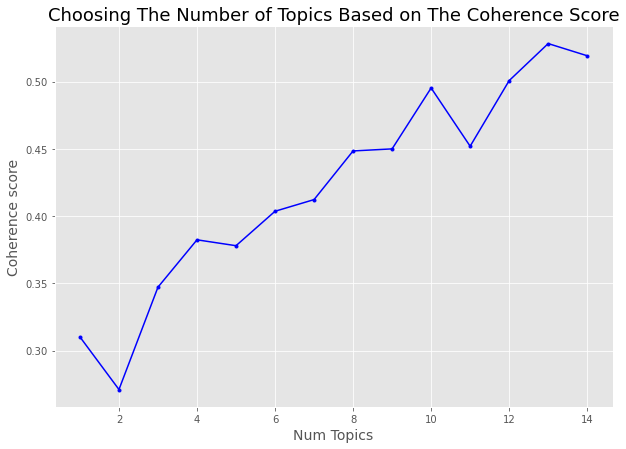

In [25]:
x = range(start, stop)
plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.plot(x, coherence_values, color = "blue",marker=".")
plt.xlabel("Num Topics", size=14)
plt.ylabel("Coherence score", size=14)
plt.title('Choosing The Number of Topics Based on The Coherence Score',size=18)
plt.show()

In [26]:
%%time

# Build LDA model
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=8,
                                             alpha='auto',
                                             eta='auto',
                                             iterations=125,
                                             per_word_topics=True)

CPU times: user 1.01 s, sys: 11.3 ms, total: 1.02 s
Wall time: 1.01 s


In [27]:
from pprint import pprint
pprint(lda_model4.print_topics())

[(0,
  '0.045*"agent" + 0.036*"cancel" + 0.029*"board" + 0.027*"online" + '
  '0.019*"phone" + 0.019*"reservation" + 0.018*"time" + 0.015*"offer" + '
  '0.015*"wait" + 0.014*"travel"'),
 (1,
  '0.033*"baggage" + 0.020*"customer" + 0.019*"fly" + 0.018*"service" + '
  '0.016*"response" + 0.016*"respond" + 0.013*"experience" + 0.011*"change" + '
  '0.011*"issue" + 0.011*"address"'),
 (2,
  '0.037*"rebooked" + 0.037*"book" + 0.036*"agents" + 0.033*"change" + '
  '0.026*"check" + 0.025*"problems" + 0.016*"phone" + 0.015*"cater" + '
  '0.014*"ticket" + 0.014*"cancel"'),
 (3,
  '0.171*"cancel" + 0.033*"luggage" + 0.025*"rebook" + 0.018*"passengers" + '
  '0.017*"email" + 0.015*"ticket" + 0.014*"delay" + 0.013*"reason" + '
  '0.012*"airlines" + 0.011*"available"'),
 (4,
  '0.056*"phone" + 0.028*"answer" + 0.028*"reservations" + 0.027*"website" + '
  '0.016*"email" + 0.012*"message" + 0.012*"ticket" + 0.011*"switch" + '
  '0.011*"twice" + 0.011*"assistance"'),
 (5,
  '0.069*"wait" + 0.029*"tick

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model4.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model4, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.114195310933829

Coherence Score:  0.450014252105399


In [29]:
lda_model4.save('LDA_details/lda_model4.model')

In [40]:
id2word = corpora.Dictionary.load('LDA_details/id2word.dict')

unseen_document = "@united has the WORST customer experience ever! first the website was down, then the boarding and checkin processes w so complicated and slow"
# unseen_document = '@TK_HelpDesk @KuwaitAirports please see the thread. 11 passengers are stressed at your airport for 7 hours due to fight between 2 Airlines @KuwaitAirways @TurkishAirlines can you do something?? Humble request for a fast solution.'
# unseen_document = '''I didn't get my preferred seat. Was uncomfortable during the entire flight.'''
# unseen_document = '''the representative did not make any accommodation for the seconds  class ticket.'''
# unseen_document ='''Hi @airindia staff, i cancelled my ticket but no refund was provided please help'''

bow_vector = id2word.doc2bow(preprocess(unseen_document))
result = lda_model4.get_document_topics(bow_vector, minimum_probability=0.0)
resultdict = dict(result)

In [41]:
orddict = sorted(resultdict, key=resultdict.get, reverse=True)

Keymax = 1

if Keymax == 1:
    print('Delay Issue')
elif Keymax == 2:
    print('Reservation Issue')
elif Keymax == 3:
    print('Baggage Issue')
elif Keymax == 4:
    print('Customer Service')
elif Keymax == 5:
    print('Rescedule Issue')
elif Keymax == 6 or Keymax == 7:
    print('Phone or Online Booking Issue')
else:
    print('Refund Issues')
print("\n")

for index, score in resultdict.items():
    print("Score: {}\n Topic: {}\n Keywords:{} \n".format(score, index+1, lda_model4.print_topic(index)))

Predicted topic:  6
Probability Score:  0.39243674
Customer Experience


Score: 0.016110960394144058
 Topic: 1
 Keywords:0.045*"agent" + 0.036*"cancel" + 0.029*"board" + 0.027*"online" + 0.019*"phone" + 0.019*"reservation" + 0.018*"time" + 0.015*"offer" + 0.015*"wait" + 0.014*"travel" 

Score: 0.20095379650592804
 Topic: 2
 Keywords:0.033*"baggage" + 0.020*"customer" + 0.019*"fly" + 0.018*"service" + 0.016*"response" + 0.016*"respond" + 0.013*"experience" + 0.011*"change" + 0.011*"issue" + 0.011*"address" 

Score: 0.014000862836837769
 Topic: 3
 Keywords:0.037*"rebooked" + 0.037*"book" + 0.036*"agents" + 0.033*"change" + 0.026*"check" + 0.025*"problems" + 0.016*"phone" + 0.015*"cater" + 0.014*"ticket" + 0.014*"cancel" 

Score: 0.014952764846384525
 Topic: 4
 Keywords:0.171*"cancel" + 0.033*"luggage" + 0.025*"rebook" + 0.018*"passengers" + 0.017*"email" + 0.015*"ticket" + 0.014*"delay" + 0.013*"reason" + 0.012*"airlines" + 0.011*"available" 

Score: 0.09014085680246353
 Topic: 5
 Keywor

In [39]:
for index, score in resultdict.items():
    print(score)

0.014239348
0.011491769
0.012427647
0.013291546
0.5716448
0.011889241
0.012370848
0.35264486


In [2]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model4, corpus, id2word,sort_topics=False)
pyLDAvis.save_html(vis, 'LDA_details/ldaviz.html')
vis